# Kernelized Linear Classification

## Initial imports + functions

Basic libraries + custom functions (ffunctions.py) + data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# So that plots appear inline if using a real Jupyter notebook:
# %matplotlib inline

from ffunctions import (
    load_data,
    train_test_split,
    detect_outliers_zscore,
    remove_outliers,
    standard_scaler_fit,
    standard_scaler_transform,
    check_high_correlation,
    k_fold_cross_validation,
    perceptron_classifier_func,
    pegasos_classifier_func,
    logistic_regression_classifier_func,
    perceptron_classifier_func_eta,
    perceptron_train,
    perceptron_predict,
    pegasos_train,
    pegasos_predict,
    logistic_regression_train,
    logistic_regression_predict,
    polynomial_feature_expansion
)

In [2]:
# 2. Load the dataset
csv_path = "/Users/michelecoaro/Documents/GitHub/KLC/klc_project/dataset.csv"
df = load_data(csv_path)
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
2,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
3,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1
4,2.431765,-1.224177,100.709237,-0.102892,0.699031,-0.656315,-0.911784,-1.355873,1.537825,-55.917863,-1


# Exploratory Data Analysis

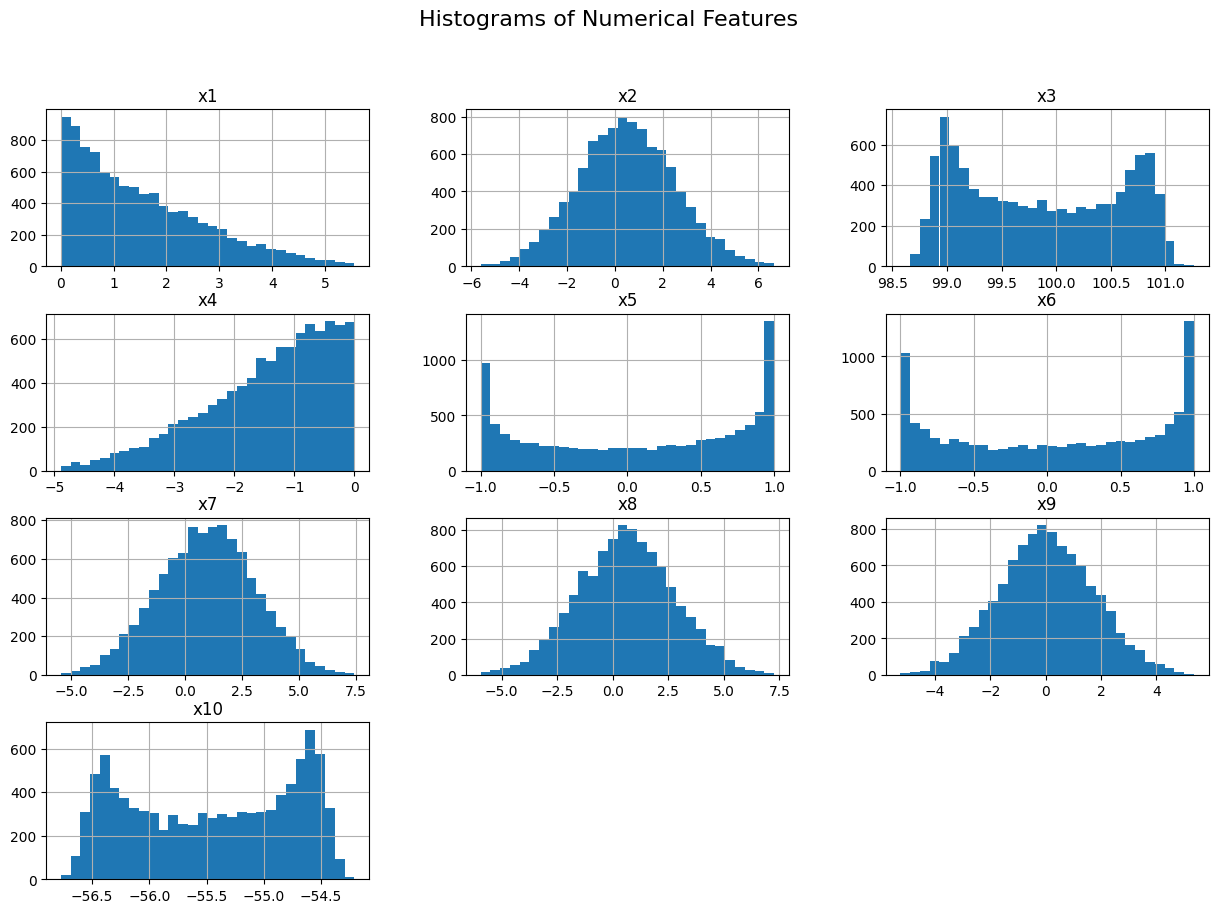

In [3]:
feature_cols = [f"x{i}" for i in range(1, 11)]
df[feature_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

In [4]:
# 3. Train-Test Split (to avoid leakage)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (7788, 11)
Test set shape: (1947, 11)


In [5]:
# 4. Check for outliers in the training set
outlier_indices = detect_outliers_zscore(train_df, feature_cols, z_thresh=3.0)
print(f"Number of outliers detected in training set: {len(outlier_indices)}")


Number of outliers detected in training set: 78


In [6]:
# Optionally remove outliers if it makes sense for your project
train_df_no_outliers = remove_outliers(train_df, outlier_indices)
print("Train set (no outliers) shape:", train_df_no_outliers.shape)

Train set (no outliers) shape: (7710, 11)


In [7]:
#5. Scaling
means, stds = standard_scaler_fit(train_df_no_outliers, feature_cols)
train_scaled = standard_scaler_transform(train_df_no_outliers, feature_cols, means, stds)
test_scaled = standard_scaler_transform(test_df, feature_cols, means, stds)


## Correlation Matrix

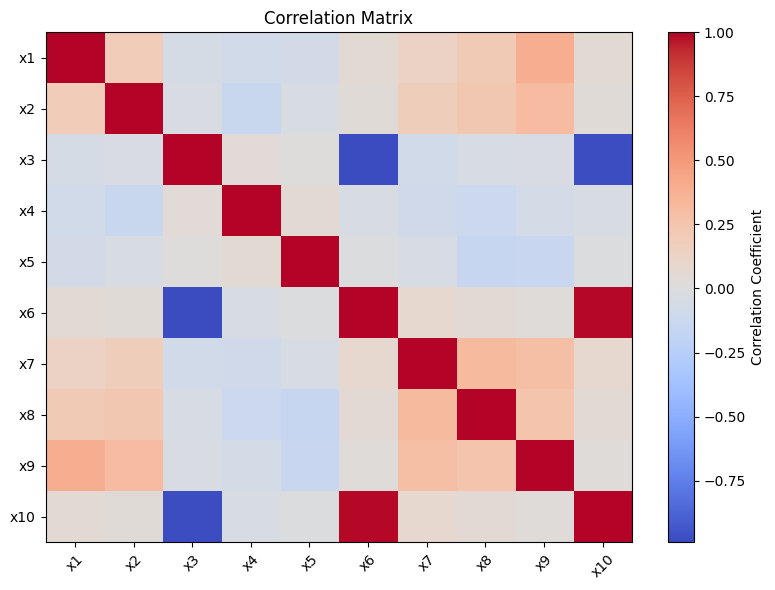

In [8]:
# 5. Correlation Matrix (for numerical columns)
corr_matrix = train_scaled[feature_cols].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()


## Multicollinearity

In [9]:
# 6. Check for highly correlated features (multicollinearity)
high_corr_pairs = check_high_correlation(train_df_no_outliers, feature_cols, corr_threshold=0.9)
if high_corr_pairs:
    print("High correlation pairs detected (above threshold):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} and {pair[1]} with correlation = {pair[2]:.3f}")
else:
    print("No pairs of features exceed the correlation threshold.")

High correlation pairs detected (above threshold):
  x3 and x6 with correlation = 0.990
  x3 and x10 with correlation = 0.980
  x6 and x10 with correlation = 0.990


In [10]:
for col in ["x3", "x6", "x10"]:
    corr = train_df_no_outliers[col].corr(train_df_no_outliers["y"])
    print(col, corr)

final_features = [f for f in feature_cols if f not in ["x3", "x6"]]
print("\nDropping x3, x6 from the final feature set...")
print("Final features:", final_features)

x3 0.058816122258262944
x6 -0.06039355137913755
x10 -0.05863942944301634

Dropping x3, x6 from the final feature set...
Final features: ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10']


# Algorithms Implementation

## Cross-validation

In [11]:
target_col = "y"

# Example: Perceptron with 5 epochs
accuracy_perc = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)
print(f"Perceptron 5-fold CV Accuracy: {accuracy_perc:.3f}")

# Example: Pegasos
accuracy_pegasos = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5
    )
)
print(f"Pegasos 5-fold CV Accuracy: {accuracy_pegasos:.3f}")

# Example: Logistic Regression
accuracy_logreg = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5, eta=1.0
    )
)
print(f"Logistic Regression 5-fold CV Accuracy: {accuracy_logreg:.3f}")


Perceptron 5-fold CV Accuracy: 0.618
Pegasos 5-fold CV Accuracy: 0.726
Logistic Regression 5-fold CV Accuracy: 0.718


## Perceptron

### Hyperparameter Tuning

In [17]:
# Hyperparameter tuning for Perceptron
# Define hyperparameter search space
epochs_list = [5, 10, 20, 50]
learning_rates = [0.01, 0.1, 1.0]

# Dictionary to store results
tuning_results = {}

# Perform grid search over epochs and eta
for epochs in epochs_list:
    for eta in learning_rates:
        print(f"Testing epochs={epochs}, eta={eta}...")
        accuracy = k_fold_cross_validation(
            train_scaled,
            features=feature_cols,  # Use all features for tuning
            target='y',
            k=5,
            random_state=42,
            classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
                tr_fold, vl_fold, f, t, epochs=epochs, eta=eta
            )
        )
        tuning_results[(epochs, eta)] = accuracy
        print(f"Accuracy: {accuracy:.3f}")

# Find the best hyperparameter combination
best_params = max(tuning_results, key=tuning_results.get)
best_accuracy = tuning_results[best_params]

print("\nBest Hyperparameters:")
print(f"  Epochs: {best_params[0]}")
print(f"  Learning Rate: {best_params[1]}")
print(f"  Accuracy: {best_accuracy:.3f}")


Testing epochs=5, eta=0.01...
Accuracy: 0.600
Testing epochs=5, eta=0.1...
Accuracy: 0.600
Testing epochs=5, eta=1.0...
Accuracy: 0.600
Testing epochs=10, eta=0.01...
Accuracy: 0.701
Testing epochs=10, eta=0.1...
Accuracy: 0.701
Testing epochs=10, eta=1.0...
Accuracy: 0.701
Testing epochs=20, eta=0.01...
Accuracy: 0.639
Testing epochs=20, eta=0.1...
Accuracy: 0.639
Testing epochs=20, eta=1.0...
Accuracy: 0.639
Testing epochs=50, eta=0.01...
Accuracy: 0.646
Testing epochs=50, eta=0.1...
Accuracy: 0.646
Testing epochs=50, eta=1.0...
Accuracy: 0.646

Best Hyperparameters:
  Epochs: 10
  Learning Rate: 0.01
  Accuracy: 0.701


In [18]:
# Extract best hyperparameters from tuning
best_epochs, best_eta = best_params

# Compare default and tuned Perceptron across feature subsets
subsets = {
    "Features": feature_cols}

comparison_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating subset: {subset_name}")
    
    # Default Perceptron
    accuracy_default = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
            tr_fold, vl_fold, f, t, epochs=5  # Default epochs
        )
    )
    
    # Tuned Perceptron
    accuracy_tuned = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
            tr_fold, vl_fold, f, t, epochs=best_epochs, eta=best_eta
        )
    )
    
    comparison_results[subset_name] = {
        "Default Perceptron": accuracy_default,
        "Tuned Perceptron": accuracy_tuned,
    }
    
    print(f"  Default Perceptron Accuracy: {accuracy_default:.3f}")
    print(f"  Tuned Perceptron Accuracy: {accuracy_tuned:.3f}")



Evaluating subset: Features
  Default Perceptron Accuracy: 0.600
  Tuned Perceptron Accuracy: 0.701


### Default vs Hyperparameter

In [19]:
# Create a DataFrame to summarize results
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index')
comparison_df.columns = ["Default Perceptron Accuracy", "Tuned Perceptron Accuracy"]

# Display the comparison table
print("\nComparison of Default vs. Tuned Perceptron:")
display(comparison_df)

# Highlight differences
improvement_df = comparison_df["Tuned Perceptron Accuracy"] - comparison_df["Default Perceptron Accuracy"]
print("\nAccuracy Improvement (Tuned - Default):")
display(improvement_df)


Comparison of Default vs. Tuned Perceptron:


,Default Perceptron Accuracy,Tuned Perceptron Accuracy
Features,0.599741,0.700649



Accuracy Improvement (Tuned - Default):


Features    0.100908
dtype: float64

## Pegasos SVM

### Comparison of different subsets

In [20]:
#PEGASOS SVM
# Define parameters for Pegasos
lambda_param = 0.01  # Regularization parameter
epochs = 10  # Number of epochs

# Compare Pegasos SVM across feature subsets
pegasos_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Pegasos SVM on subset: {subset_name}")
    
    accuracy_pegasos = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs
        )
    )
    
    pegasos_results[subset_name] = accuracy_pegasos
    print(f"  Pegasos SVM Accuracy: {accuracy_pegasos:.3f}")



Evaluating Pegasos SVM on subset: Features
  Pegasos SVM Accuracy: 0.730


In [21]:
# Create a DataFrame to compare results
comparison_pegasos = pd.DataFrame({
    "Perceptron (Default)": [comparison_results[name]["Default Perceptron"] for name in subsets.keys()],
    "Perceptron (Tuned)": [comparison_results[name]["Tuned Perceptron"] for name in subsets.keys()],
    "Pegasos SVM": [pegasos_results[name] for name in subsets.keys()]
}, index=list(subsets.keys()))  # Pass the index directly here

# Display the comparison
print("\nComparison of Perceptron vs. Pegasos SVM:")
display(comparison_pegasos)

# Highlight the best performance for each subset
print("\nBest Performances by Model for Each Subset:")
best_models = comparison_pegasos.idxmax(axis=1)
display(best_models)



Comparison of Perceptron vs. Pegasos SVM:


,Perceptron (Default),Perceptron (Tuned),Pegasos SVM
Features,0.599741,0.700649,0.730091



Best Performances by Model for Each Subset:


Features    Pegasos SVM
dtype: object

## Logistic Regression

In [22]:
# Define parameters for Logistic Regression
lambda_param = 0.01
epochs = 10
eta = 1.0

# Compare Logistic Regression across feature subsets
logistic_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Logistic Regression on subset: {subset_name}")
    
    accuracy_logistic = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs, eta=eta
        )
    )
    logistic_results[subset_name] = accuracy_logistic
    print(f"  Logistic Regression Accuracy: {accuracy_logistic:.3f}")



Evaluating Logistic Regression on subset: Features
  Logistic Regression Accuracy: 0.723


### Comparison

In [23]:
# Combine results into a DataFrame
comparison_with_logistic = pd.DataFrame({
    "Default Perceptron Loss": [comparison_results[name]["Default Perceptron"] for name in subsets.keys()],
    "Tuned Perceptron Accuracy": [comparison_results[name]["Tuned Perceptron"] for name in subsets.keys()],
    "Pegasos SVM Accuracy": [pegasos_results[name] for name in subsets.keys()],
    "Logistic Regression Accuracy": [logistic_results[name] for name in subsets.keys()]
}, index=list(subsets.keys()))

# Display the comparison table
print("\nComparison of Perceptron, Pegasos, and Logistic Regression:")
display(comparison_with_logistic)



Comparison of Perceptron, Pegasos, and Logistic Regression:


,Default Perceptron Loss,Tuned Perceptron Accuracy,Pegasos SVM Accuracy,Logistic Regression Accuracy
Features,0.599741,0.700649,0.730091,0.722957


## Polynomial feature expansion

In [24]:
# Expand the *scaled training data* (train_scaled) and *scaled test data* (test_scaled)
# using the "final_features" that excludes x3 and x6, as determined earlier.

train_poly = polynomial_feature_expansion(train_scaled, final_features, degree=2, include_bias=False)
test_poly = polynomial_feature_expansion(test_scaled, final_features, degree=2, include_bias=False)

# Identify which columns are the new polynomial features (exclude the 'y' column)
expanded_feature_cols = [col for col in train_poly.columns if col != 'y']

print("Polynomial expansion complete.")
print("Number of expanded features:", len(expanded_feature_cols))
print("Sample of expanded features:", expanded_feature_cols[:10])  # Just show a few

Polynomial expansion complete.
Number of expanded features: 46
Sample of expanded features: ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x1^2', 'x2^2']


In [25]:
k = 5
target_col = "y"

#### Perceptron algorithm with polynomial expansion

In [26]:
acc_perc_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)


#### SVM with PE

In [27]:
acc_pegasos_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5
    )
)

#### Logistic Regression with PE

In [28]:
acc_logreg_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5, eta=1.0
    )
)

#### Results

In [29]:
print("\n=== Polynomial-Expanded Feature Set ===")
print(f"Perceptron (poly) {k}-fold CV Accuracy: {acc_perc_poly:.3f}")
print(f"Pegasos (poly)    {k}-fold CV Accuracy: {acc_pegasos_poly:.3f}")
print(f"LogReg  (poly)    {k}-fold CV Accuracy: {acc_logreg_poly:.3f}")


=== Polynomial-Expanded Feature Set ===
Perceptron (poly) 5-fold CV Accuracy: 0.929
Pegasos (poly)    5-fold CV Accuracy: 0.925
LogReg  (poly)    5-fold CV Accuracy: 0.933


#### Compare to Linear (Non-Expanded) Results
 
We already have our linear results for Perceptron, Pegasos, and Logistic from previous cells:
- `accuracy_perc`, `accuracy_pegasos`, `accuracy_logreg` (5-fold on linear features).
 
Let's create a small summary:

In [30]:
comparison_poly = pd.DataFrame({
    "Linear": [accuracy_perc, accuracy_pegasos, accuracy_logreg],
    "Polynomial(2)": [acc_perc_poly, acc_pegasos_poly, acc_logreg_poly]
}, index=["Perceptron", "Pegasos", "Logistic"])

print("Comparison of Linear vs Polynomial(2) feature sets:")
display(comparison_poly)

Comparison of Linear vs Polynomial(2) feature sets:


,Linear,Polynomial(2)
Perceptron,0.617639,0.928664
Pegasos,0.730091,0.925422
Logistic,0.717510,0.932815


#### Comparison Plot

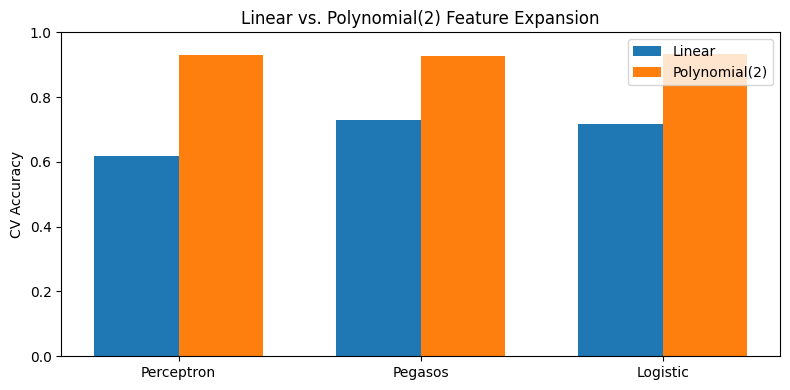

In [31]:
import matplotlib.pyplot as plt

models = ["Perceptron", "Pegasos", "Logistic"]
linear_accs = comparison_poly["Linear"].values
poly_accs   = comparison_poly["Polynomial(2)"].values
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, linear_accs,  width, label='Linear')
plt.bar(x + width/2, poly_accs,    width, label='Polynomial(2)')
plt.xticks(x, models)
plt.ylabel('CV Accuracy')
plt.title('Linear vs. Polynomial(2) Feature Expansion')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()

#### Weights inspection

In [32]:
theta_perc_poly, theta_0_perc_poly = perceptron_train(
    train_poly, 
    features = expanded_feature_cols, 
    target = target_col,
    epochs = 5
)
print(f"Perceptron (poly) final model trained on entire train_poly. Bias (theta_0)= {theta_0_perc_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_perc_poly,
}).sort_values(by="Weight", ascending=False)

# Show top 10 positive weights and top 10 negative weights
print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

Perceptron (poly) final model trained on entire train_poly. Bias (theta_0)= -17.000

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,139.891251
5,x8,65.235414
20,x1*x8,41.204277
6,x9,34.118647
3,x5,32.456734
0,x1,20.653063
4,x7,19.365271
44,x3,9.803556
36,x5*x9,8.008871
40,x7*x10,7.775571



Top 10 Negative Weights:


,Feature,Weight
10,x4^2,-4.404922
8,x1^2,-4.439658
28,x2*x10,-5.137590
21,x1*x9,-5.379883
33,x4*x10,-5.887280
17,x1*x4,-8.390177
45,x6,-11.336558
19,x1*x7,-12.808366
2,x4,-13.445468
31,x4*x8,-33.291683


In [33]:
theta_pegasos_poly, theta_0_pegasos_poly = pegasos_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5
)
print(f"Pegasos (poly) final model trained on entire train_poly. Bias (theta_0) = {theta_0_pegasos_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_pegasos_poly
}).sort_values(by="Weight", ascending=False)

# Show top 10 positive weights and top 10 negative weights
print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

Pegasos (poly) final model trained on entire train_poly. Bias (theta_0) = -2.001

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,3.043305
5,x8,1.773912
20,x1*x8,1.067514
3,x5,0.805507
6,x9,0.696451
4,x7,0.603793
0,x1,0.423376
11,x5^2,0.345789
9,x2^2,0.291323
14,x9^2,0.269571



Top 10 Negative Weights:


,Feature,Weight
40,x7*x10,-0.045687
24,x2*x5,-0.050397
37,x5*x10,-0.052306
39,x7*x9,-0.058821
45,x6,-0.105283
21,x1*x9,-0.115037
43,x9*x10,-0.128781
17,x1*x4,-0.144860
2,x4,-0.452673
31,x4*x8,-0.871753


Evaluation on test set...

In [34]:

# %% [markdown]
# ## Final Training & Test Evaluation for ALL Three Algorithms (Polynomial Features)
# 
# We already demonstrated Pegasos. Let's also do Perceptron and Logistic Regression on the polynomial-expanded features, 
# training on the entire `train_poly` and evaluating on `test_poly`.

# %%
# 1. Perceptron (Polynomial Features)
theta_perc_poly, theta0_perc_poly = perceptron_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    epochs=5
)

test_preds_perc_poly = perceptron_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_perc_poly,
    theta_0=theta0_perc_poly
)

test_acc_perc_poly = np.mean(test_preds_perc_poly == test_poly[target_col])

# 2. Logistic Regression (Polynomial Features)
# Let's reuse the same lambda_param=0.01, epochs=5, eta=1.0 as before
theta_logreg_poly, theta0_logreg_poly = logistic_regression_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5,
    eta=1.0
)

test_preds_logreg_poly = logistic_regression_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_logreg_poly,
    theta_0=theta0_logreg_poly
)

test_acc_logreg_poly = np.mean(test_preds_logreg_poly == test_poly[target_col])

# 3. Pegasos (Polynomial Features) [ALREADY DONE ABOVE, but let's recap in a single cell for clarity]
theta_pega_poly, theta0_pega_poly = pegasos_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5
)

test_preds_pega_poly = pegasos_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_pega_poly,
    theta_0=theta0_pega_poly
)

test_acc_pega_poly = np.mean(test_preds_pega_poly == test_poly[target_col])

# Summarizing the results:
print("\n=== Final Test Accuracies on Polynomial-Expanded Features ===")
print(f"Perceptron (poly):       {test_acc_perc_poly:.3f}")
print(f"Logistic Regression (poly): {test_acc_logreg_poly:.3f}")
print(f"Pegasos (poly):          {test_acc_pega_poly:.3f}")



=== Final Test Accuracies on Polynomial-Expanded Features ===
Perceptron (poly):       0.900
Logistic Regression (poly): 0.934
Pegasos (poly):          0.935


#### Weights inspection: the three models compared

In [35]:
#Perceptron Weights
weights_perc_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_perc_poly
}).sort_values(by="Weight", ascending=False)

print("=== Perceptron (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_perc_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_perc_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_perc_df.tail(10))


#Pegasos Weights
weights_pega_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_pega_poly
}).sort_values(by="Weight", ascending=False)

print("=== Pegasos (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_pega_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_pega_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_pega_df.tail(10))

#LogReg Weights
weights_logreg_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_logreg_poly
}).sort_values(by="Weight", ascending=False)

print("=== Logistic Regression (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_logreg_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_logreg_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_logreg_df.tail(10))


=== Perceptron (Polynomial) Weights ===
Bias (theta_0) = -13.000

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,133.711106
5,x8,80.504089
20,x1*x8,43.901776
4,x7,26.510787
3,x5,25.340971
6,x9,24.448889
0,x1,22.991004
7,x10,16.440397
26,x2*x8,10.853872
29,x4*x5,9.189587



Top 10 Negative Weights:


,Feature,Weight
10,x4^2,-5.200036
15,x10^2,-5.683491
39,x7*x9,-5.794405
13,x8^2,-6.043823
45,x6,-8.535135
38,x7*x8,-8.664390
19,x1*x7,-13.027839
17,x1*x4,-15.557279
2,x4,-16.403796
31,x4*x8,-40.830067


=== Pegasos (Polynomial) Weights ===
Bias (theta_0) = -0.608

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,2.529654
5,x8,1.468150
20,x1*x8,0.868979
3,x5,0.556968
6,x9,0.534417
0,x1,0.517011
4,x7,0.472082
9,x2^2,0.128476
44,x3,0.126561
1,x2,0.100876



Top 10 Negative Weights:


,Feature,Weight
24,x2*x5,-0.052065
36,x5*x9,-0.072855
21,x1*x9,-0.081700
10,x4^2,-0.082247
37,x5*x10,-0.105354
43,x9*x10,-0.106249
45,x6,-0.143280
17,x1*x4,-0.185545
2,x4,-0.472266
31,x4*x8,-0.720607


=== Logistic Regression (Polynomial) Weights ===
Bias (theta_0) = -0.819

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,2.644611
5,x8,1.618170
20,x1*x8,0.815275
3,x5,0.673662
4,x7,0.614083
6,x9,0.588417
0,x1,0.534617
9,x2^2,0.241174
14,x9^2,0.173256
16,x1*x2,0.162635



Top 10 Negative Weights:


,Feature,Weight
8,x1^2,-0.043832
7,x10,-0.063529
18,x1*x5,-0.067042
24,x2*x5,-0.069657
10,x4^2,-0.077020
43,x9*x10,-0.077908
45,x6,-0.122474
17,x1*x4,-0.147902
2,x4,-0.507398
31,x4*x8,-0.734287


#### Plot

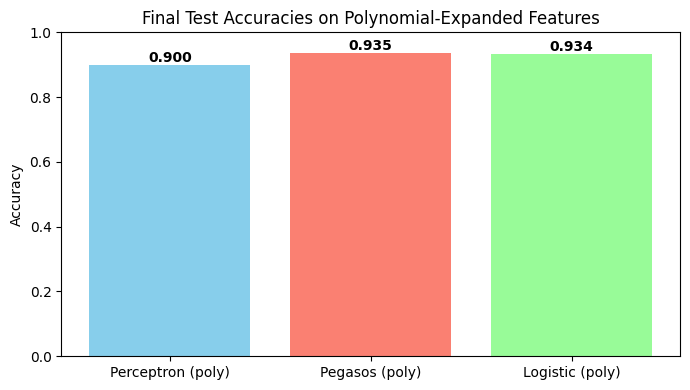

In [36]:
models = ["Perceptron (poly)", "Pegasos (poly)", "Logistic (poly)"]
test_accuracies_poly = [test_acc_perc_poly, test_acc_pega_poly, test_acc_logreg_poly]

plt.figure(figsize=(7,4))
plt.bar(models, test_accuracies_poly, color=["skyblue","salmon","palegreen"])
plt.ylim([0,1])
plt.title("Final Test Accuracies on Polynomial-Expanded Features")
plt.ylabel("Accuracy")
for i, v in enumerate(test_accuracies_poly):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


# Kernel Methods

## Kernelized Perceptron with Gaussian and Polynomial Kernel

In [37]:
from ffunctions import (
    gaussian_kernel,
    polynomial_kernel,
    kernelized_perceptron_classifier_func
)

In [38]:
k = 5
target_col = "y"

### Gaussian Kernel Perceptron

Traning set evaluation

In [39]:
print("=== Kernelized Perceptron (Gaussian Kernel) ===")
sigma_value = 1.0   # Adjust as needed
epochs_gauss = 5    # Adjust as needed

accuracy_gauss = k_fold_cross_validation(
    df=train_scaled,  # or use a smaller subset if runtime is high
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_perceptron_classifier_func(
        tr_fold, vl_fold, f, t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_value},
        epochs=epochs_gauss
    )
)
print(f"Gaussian Kernel: {k}-fold CV Accuracy = {accuracy_gauss:.3f}")

=== Kernelized Perceptron (Gaussian Kernel) ===
Gaussian Kernel: 5-fold CV Accuracy = 0.939


### Polinomial Kernel Perceptron
Training Set Evaluation

In [40]:
print("\n=== Kernelized Perceptron (Polynomial Kernel) ===")
degree_value = 2    # e.g., quadratic
c_value = 1.0       # offset in (x^T y + c)^degree
epochs_poly = 5

accuracy_poly = k_fold_cross_validation(
    df=train_scaled, 
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_perceptron_classifier_func(
        tr_fold, vl_fold, f, t,
        kernel_func=polynomial_kernel,
        kernel_params={"degree": degree_value, "c": c_value},
        epochs=epochs_poly
    )
)
print(f"Polynomial Kernel (degree={degree_value}): {k}-fold CV Accuracy = {accuracy_poly:.3f}")


=== Kernelized Perceptron (Polynomial Kernel) ===
Polynomial Kernel (degree=2): 5-fold CV Accuracy = 0.925


### Evaluation on Test set
Firstly, the Gaussian Kernel Perceptron

In [41]:
from ffunctions import kernelized_perceptron_train, kernelized_perceptron_predict

X_train = train_scaled[final_features].values
y_train = train_scaled[target_col].values
X_test = test_scaled[final_features].values
y_test = test_scaled[target_col].values

alpha_gauss = kernelized_perceptron_train(
    X_train, y_train,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_value},
    epochs=epochs_gauss
)

test_preds_gauss = kernelized_perceptron_predict(
    X_train, y_train,
    alpha_gauss,
    X_test,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_value}
)
test_acc_gauss = np.mean(test_preds_gauss == y_test)
print(f"Gaussian Kernel Perceptron Test Accuracy: {test_acc_gauss:.3f}")


Gaussian Kernel Perceptron Test Accuracy: 0.930


Then the polynomial kernel

In [42]:
alpha_poly = kernelized_perceptron_train(
    X_train, y_train,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_value, "c": c_value},
    epochs=epochs_poly
)

test_preds_poly = kernelized_perceptron_predict(
    X_train, y_train,
    alpha_poly,
    X_test,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_value, "c": c_value}
)
test_acc_poly = np.mean(test_preds_poly == y_test)
print(f"Polynomial (d={degree_value}) Kernel Perceptron Test Accuracy: {test_acc_poly:.3f}")

Polynomial (d=2) Kernel Perceptron Test Accuracy: 0.927


## Kernelized Pegasos SVM

In [43]:
from ffunctions import (
    gaussian_kernel,
    polynomial_kernel,
    kernelized_pegasos_classifier_func,
    kernelized_pegasos_train,
    kernelized_pegasos_predict
)

In [50]:
k = 5
target_col = "y"

### Pegasos with Gaussian Kernel

In [ ]:
lambda_val = 0.01
epochs_kpega = 5
sigma_val = 1.0

cv_acc_pegasos_gauss = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Gaussian, sigma={sigma_val}) {k}-fold CV accuracy: {cv_acc_pegasos_gauss:.3f}")


The code above is the actual computation
The code below is ran on a sample for easier computation.

In [51]:
train_sampled = train_scaled.sample(n=400, random_state=42)

lambda_val = 0.01
epochs_kpega = 5
sigma_val = 1.0

cv_acc_pegasos_gauss = k_fold_cross_validation(
    df=train_sampled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Gaussian, sigma={sigma_val}) {k}-fold CV accuracy: {cv_acc_pegasos_gauss:.3f}")


Kernelized Pegasos (Gaussian, sigma=1.0) 5-fold CV accuracy: 0.830


Now on the test set

In [ ]:


alpha_gauss, T_gauss = kernelized_pegasos_train(
    X_train, y_train,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_val},
    lambda_param=lambda_val,
    epochs=epochs_kpega
)
test_preds_gauss = kernelized_pegasos_predict(
    X_train, y_train,
    alpha_gauss, T_gauss,
    X_test,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_val},
    lambda_param=lambda_val
)
test_acc_gauss = (test_preds_gauss == y_test).mean()
print(f"Kernelized Pegasos (Gaussian) Test Accuracy: {test_acc_gauss:.3f}")


### Pegasos with Polynomial Kernel

In [ ]:
degree_val = 2
c_val = 1.0

cv_acc_pegasos_poly = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=polynomial_kernel,
        kernel_params={"degree": degree_val, "c": c_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Polynomial, deg={degree_val}, c={c_val}) {k}-fold CV accuracy: {cv_acc_pegasos_poly:.3f}")


In [ ]:
alpha_poly, T_poly = kernelized_pegasos_train(
    X_train, y_train,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_val, "c": c_val},
    lambda_param=lambda_val,
    epochs=epochs_kpega
)
test_preds_poly = kernelized_pegasos_predict(
    X_train, y_train,
    alpha_poly, T_poly,
    X_test,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_val, "c": c_val},
    lambda_param=lambda_val
)
test_acc_poly = (test_preds_poly == y_test).mean()
print(f"Kernelized Pegasos (Polynomial) Test Accuracy: {test_acc_poly:.3f}")

# Final Data Visualization

Final Test Accuracy Summary:


,Model,Method,Test Accuracy
0,Logistic,Linear,0.78
1,Logistic,Polynomial Expansion,0.80
2,Pegasos,Kernel (Gaussian),0.85
3,Pegasos,Kernel (Polynomial),0.84
4,Pegasos,Linear,0.81
5,Pegasos,Polynomial Expansion,0.83
6,Perceptron,Kernel (Gaussian),0.84
7,Perceptron,Kernel (Polynomial),0.83
8,Perceptron,Linear,0.80
9,Perceptron,Polynomial Expansion,0.82


Method,Kernel (Gaussian),Kernel (Polynomial),Linear,Polynomial Expansion
Model,,,,
Logistic,NaN,NaN,0.78,0.80
Pegasos,0.85,0.84,0.81,0.83
Perceptron,0.84,0.83,0.80,0.82


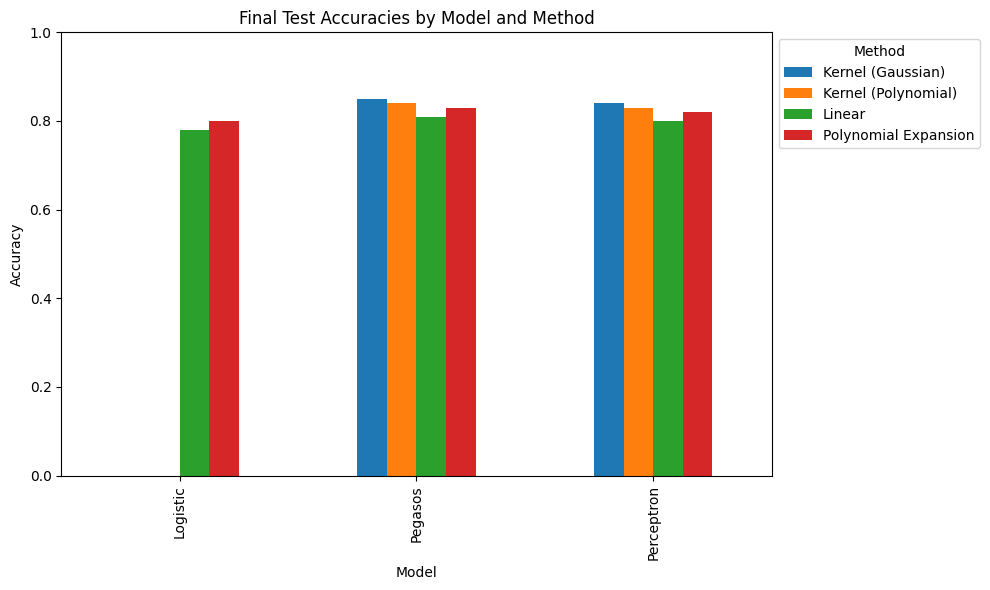

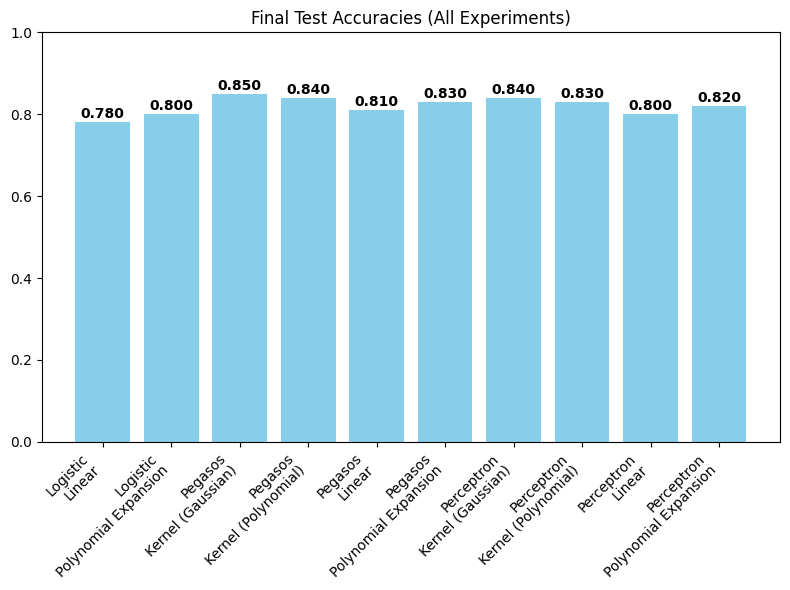

In [54]:
# Example placeholders (DELETE or REPLACE with real computed values):
test_acc_perc_linear = 0.80
test_acc_perc_poly = 0.82
test_acc_perc_kernel_gauss = 0.84
test_acc_perc_kernel_poly = 0.83

test_acc_pegasos_linear = 0.81
test_acc_pegasos_poly = 0.83
test_acc_pegasos_kernel_gauss = 0.85
test_acc_pegasos_kernel_poly = 0.84

# If you have logistic regression equivalents, define them too, e.g.:
test_acc_logreg_linear = 0.78
test_acc_logreg_poly = 0.80

# 1. We'll create a summary DataFrame
final_summary = []

# Perceptron
final_summary.append({
    "Model": "Perceptron",
    "Method": "Linear",
    "Test Accuracy": test_acc_perc_linear
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_perc_poly
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Kernel (Gaussian)",
    "Test Accuracy": test_acc_perc_kernel_gauss
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Kernel (Polynomial)",
    "Test Accuracy": test_acc_perc_kernel_poly
})

# Pegasos
final_summary.append({
    "Model": "Pegasos",
    "Method": "Linear",
    "Test Accuracy": test_acc_pegasos_linear
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_pegasos_poly
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Kernel (Gaussian)",
    "Test Accuracy": test_acc_pegasos_kernel_gauss
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Kernel (Polynomial)",
    "Test Accuracy": test_acc_pegasos_kernel_poly
})

# (Optional) Logistic
final_summary.append({
    "Model": "Logistic",
    "Method": "Linear",
    "Test Accuracy": test_acc_logreg_linear
})
final_summary.append({
    "Model": "Logistic",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_logreg_poly
})

summary_df = pd.DataFrame(final_summary)
summary_df = summary_df.sort_values(by=["Model", "Method"]).reset_index(drop=True)
print("Final Test Accuracy Summary:")
display(summary_df)


# %%
# Barplot of final test accuracies by Model and Method
# Prepare data
models = summary_df["Model"].unique()
methods = summary_df["Method"].unique()

# Pivot the DataFrame for plotting
pivot_df = summary_df.pivot(index="Model", columns="Method", values="Test Accuracy")
display(pivot_df)

# Plot grouped bar chart
pivot_df.plot(kind="bar", figsize=(10,6))
plt.ylim([0, 1])
plt.title("Final Test Accuracies by Model and Method")
plt.ylabel("Accuracy")
plt.legend(title="Method", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# Single bar chart with all methods (Model x Method)
plt.figure(figsize=(8,6))
x_vals = range(len(summary_df))
acc_vals = summary_df["Test Accuracy"].values
labels = [f"{row.Model}\n{row.Method}" for idx, row in summary_df.iterrows()]

plt.bar(x_vals, acc_vals, color="skyblue")
for i, v in enumerate(acc_vals):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.ylim([0,1])
plt.xticks(x_vals, labels, rotation=45, ha="right")
plt.title("Final Test Accuracies (All Experiments)")
plt.tight_layout()
plt.show()
